In [73]:

import math
import copy
from dataclasses import dataclass
from typing import Optional, Tuple, List

import torch
import torch.nn as nn
import torch.nn.functional as F
# ----------------------------
# Layers
# ----------------------------

class LayerNorm(nn.Module):
    """ LayerNorm with optional learnable negative bias via -softplus(bias) """
    def __init__(self, ndim: int, bias: bool = True):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.use_bias = bias
        if bias:
            self.bias = nn.Parameter(torch.zeros(ndim))
        else:
            self.register_parameter("bias", None)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b = -F.softplus(self.bias) if self.use_bias else None
        return F.layer_norm(x, self.weight.shape, self.weight, b, 1e-5)

class LinearNegativeBias(nn.Module):
    """ Linear with non-positive bias via -softplus() """
    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        self.weight = nn.Parameter(torch.empty(out_features, in_features))
        nn.init.kaiming_uniform_(self.weight, a=5 ** 0.5)
        self._bias_raw = nn.Parameter(torch.zeros(out_features))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.linear(x, self.weight, -F.softplus(self._bias_raw))

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc    = LinearNegativeBias(config.n_embd, 4 * config.n_embd)
        self.scale = math.pi / math.sqrt(3.0)
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.c_fc(x)
        x =   x * torch.sigmoid(self.scale * x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

def variance_scaled_softmax(scores, dim: int = -1, eps: float = 1e-6):
    # scores may contain -inf from masking
    finite = torch.isfinite(scores)
    m = finite.to(scores.dtype)                     # 1 where valid, 0 where masked
    n = m.sum(dim=dim, keepdim=True).clamp_min(1)  # count of valid entries per row

    # mean/var over valid entries only (population var)
    safe_scores = torch.where(finite, scores, torch.zeros_like(scores))
    mean = (safe_scores * m).sum(dim=dim, keepdim=True) / n
    var  = ((safe_scores - mean)**2 * m).sum(dim=dim, keepdim=True) / n
    std  = var.clamp_min(eps).sqrt()

    scaled = (safe_scores - mean) / std
    scaled = torch.where(finite, scaled, float('-inf'))  # restore mask
    out = torch.softmax(scaled, dim=dim)
    out = torch.where(n == 0, torch.zeros_like(out), out)  # fully-masked rows -> zeros
    return out

# ----------------------------
# 2D EM-like convective–diffusive updater (time-causal; mixes across heads)
# ----------------------------
class EMDiffuse2D(nn.Module):
    """
    Evolve X on a (time T × heads H) grid using geometry G (same shape) to
    produce per-position, per-channel coefficients:
        a_t : advection speed along time (forward only, upwind in T)
        d_t : diffusion along time (backward Laplacian in T)
        d_h : diffusion across heads (nearest-neighbor Laplacian at t-1)

    Update (per pass), for t>=0, h in [0..H-1]:
        X^{new}_{t,h} = X_{t,h}
                        + dt * [ -a_t * (X_{t,h} - X_{t-1,h})
                                 + d_t * (X_{t,h} - 2 X_{t-1,h} + X_{t-2,h})
                                 + d_h * (X_{t-1,h+1} + X_{t-1,h-1} - 2 X_{t-1,h}) ]

    Notes:
      • Causal in time: only uses t, t-1, t-2. No look-ahead.
      • Cross-head mixing uses data from t-1, so effects manifest only downstream in time.
      • Coeffs come from G via a small linear; clamped for stability.
    """
    def __init__(self, dim: int, n_passes: int = 1,
                 a_max: float = 1.0, d_t_max: float = 0.35, d_h_max: float = 0.15):
        super().__init__()
        self.dim = dim
        self.n_passes = max(1, int(n_passes))
        self.a_max = float(a_max)
        self.d_t_max = float(d_t_max)
        self.d_h_max = float(d_h_max)

        # geometry -> [a_t, d_t, d_h] per channel
        self.coeff = nn.Linear(dim, 3*dim, bias=True)
        nn.init.xavier_uniform_(self.coeff.weight)
        nn.init.zeros_(self.coeff.bias)

        # learnable global step in (0,1)
        self._dt = nn.Parameter(torch.tensor(0.5))

    def _pad_time(self, X, k=1):
        # prepend k zeros along time
        B, T, H, D = X.shape
        z = torch.zeros(B, k, H, D, device=X.device, dtype=X.dtype)
        return torch.cat([z, X[:, :T-k]], dim=1) if k <= T else torch.cat([z, z[:, :0]], dim=1)

    def _lap_head_prev(self, X_tm1):
        # head Laplacian at t-1 with zero boundary (minimal bleed at edges)
        B, T, H, D = X_tm1.shape
        left  = torch.cat([torch.zeros(B, T, 1, D, device=X_tm1.device, dtype=X_tm1.dtype),
                           X_tm1[:, :, :-1]], dim=2)
        right = torch.cat([X_tm1[:, :, 1:],
                           torch.zeros(B, T, 1, D, device=X_tm1.device, dtype=X_tm1.dtype)], dim=2)
        return left + right - 2.0 * X_tm1

    def forward(self, X: torch.Tensor, G: torch.Tensor) -> torch.Tensor:
        """
        X, G: (B*, T, H, D)
        """
        assert X.shape == G.shape and X.dim() == 4, "X,G must be (B*,T,H,D)"
        Bstar, T, H, D = X.shape
        assert D == self.dim

        # coefficients from geometry; clamp for stability
        cg = self.coeff(G)                      # (B*, T, H, 3D)
        a_raw, dt_raw, dh_raw = torch.chunk(cg, 3, dim=-1)
        a_t  = torch.sigmoid(a_raw) * self.a_max           # [0, a_max]
        d_t  = (F.softplus(dt_raw) / (1.0 + F.softplus(dt_raw))) * self.d_t_max  # [0, d_t_max]
        d_h  = (F.softplus(dh_raw) / (1.0 + F.softplus(dh_raw))) * self.d_h_max  # [0, d_h_max]

        # causal time neighbors
        X_tm1 = self._pad_time(X, k=1)
        X_tm2 = self._pad_time(X, k=2)

        # head Laplacian taken at t-1 (so cross-head influence appears downstream only)
        lap_h_prev = self._lap_head_prev(X_tm1)

        # global causal step
        dt = torch.sigmoid(self._dt)  # (0,1)

        Xn = X
        for _ in range(self.n_passes):
            # recompute causal neighbors from current state
            Xm1 = self._pad_time(Xn, k=1)
            Xm2 = self._pad_time(Xn, k=2)
            lap_h_prev = self._lap_head_prev(Xm1)

            # upwind first difference in time, backward Laplacian in time
            dx_t  = Xn - Xm1
            lap_t = Xn - 2.0*Xm1 + Xm2

            update = -a_t * dx_t + d_t * lap_t + d_h * lap_h_prev
            Xn = Xn + dt * update

        return Xn

# ----------------------------
# Wire into attention: evolve q with 2D EM-like updater using v as geometry
# ----------------------------
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.head_dim = self.n_embd // self.n_head
        assert self.n_embd % self.n_head == 0

        self.c_q = nn.Linear(self.n_embd, self.n_head * self.head_dim, bias=False)
        self.c_k = nn.Linear(self.n_embd, self.n_head * self.head_dim, bias=False)
        self.c_v = nn.Linear(self.n_embd, self.n_head * self.head_dim, bias=False)
        self.c_proj = nn.Linear(self.n_embd, self.n_embd, bias=False)

        # 2D time-causal updater: mixes across heads via (t-1) head-Laplacian
        self.em2d = EMDiffuse2D(self.head_dim, n_passes=1,
                                a_max=1.0, d_t_max=0.35, d_h_max=0.15)

        self.register_buffer(
            "mask",
            torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size)
        )
        # rope-like signifier: 2D phase over (time, head) mapped into head_dim


    def forward(self, x):
        B, T, C = x.size()
        H, Dh = self.n_head, self.head_dim

        # project
        q = self.c_q(x).view(B, T, H, Dh)
        k = self.c_k(x).view(B, T, H, Dh)
        v = self.c_v(x).view(B, T, H, Dh)


        # evolve q and k on (T x H) with their respective geometry
        q = self.em2d(q, v)
        k = self.em2d(k, v)
        # attention expects (B, H, T, Dh)
        q = q.permute(0, 2, 1, 3).contiguous()
        k = k.permute(0, 2, 1, 3).contiguous()
        v = v.permute(0, 2, 1, 3).contiguous()

        # scaled dot-product attention with causal mask
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))
        att = variance_scaled_softmax(att, dim=-1)
        y = att @ v

        # merge heads
        y = y.transpose(1, 2).contiguous().view(B, T, -1)
        y = self.c_proj(y)
        return y






# ----------------------------
# Transformer Block
# ----------------------------

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=None)
        self.mlp = MLP(config)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
         x = x + self.attn(self.ln_1(x))
         x = x + self.mlp(self.ln_2(x))
         return x

def soft_ce(logits: torch.Tensor, target_probs: torch.Tensor) -> torch.Tensor:
    logp = F.log_softmax(logits, dim=-1)
    loss = -(target_probs * logp).sum(dim=-1)
    return loss.mean()

def sharpen_distribution(idx: torch.Tensor, p: torch.Tensor, V: int, alpha: float) -> torch.Tensor:
    B, T, K = idx.shape
    out = torch.full((B, T, V), 0.0, dtype=p.dtype, device=p.device)
    q = torch.clamp(p, min=1e-12) ** alpha
    q = q / q.sum(dim=-1, keepdim=True)
    out.scatter_add_(dim=-1, index=idx, src=q)
    return out



@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 66
    n_layer: int = 4
    n_head: int = 8
    n_embd: int = 128
    n_kv_head: int = 8
    dropout: float = 0.0
    bias: bool = True

class GPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict({
            "wte": nn.Embedding(
                config.vocab_size, config.n_embd),
            "h": nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            "ln_f": LayerNorm(config.n_embd, bias=config.bias),
        })
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)


    def init_weights(self):
        self.apply(self._init_weights)
        # zero out classifier weights
        torch.nn.init.zeros_(self.lm_head.weight)
        # zero out c_proj weights in all blocks
        for block in self.transformer.h:
            torch.nn.init.zeros_(block.mlp.c_proj.weight)
            torch.nn.init.zeros_(block.attn.c_proj.weight)
        # init the rotary embeddings
        head_dim = self.config.n_embd // self.config.n_head
        # Cast the embeddings from fp32 to bf16: optim can tolerate it and it saves memory: both in the model and the activations
        if self.transformer.wte.weight.device.type == "cuda":
            self.transformer.wte.to(dtype=torch.bfloat16)

    # ------------------------
    # Forward
    # ------------------------

    def forward(self,
                idx: torch.Tensor,
                targets: Optional[torch.Tensor] = None,
                zb: Optional[Tuple[torch.Tensor, torch.Tensor]] = None):
        """
        idx: (B, T) Long
        targets: (B, T) Long or None
        zb: tuple (Z_idx, Z_p) for distributional aux 
       
        """
        device = idx.device
        B, T = idx.size()

        T0 = 0 

        tok_emb = self.transformer["wte"](idx)                 # (B, T, D)
        x = tok_emb

        # defaults
        L = len(self.transformer["h"])
        depth_alphas = [0.8 + 1.2 * (i/(L-1)) for i in range(L)] if L > 1 else [1.0]
        x = norm(x)
        # aux distribution pack
        Z_idx, Z_p = zb if zb is not None else (None, None)
        aux_loss = None

        # blocks
        for bidx, block in enumerate(self.transformer["h"]):
            x = block(x)                                       # (B, T, D)

            # in-pass early head for self-teaching
            #  Z-based distributional aux loss 
            if (Z_idx is not None) and (Z_p is not None):
                V = self.lm_head.out_features
                logits_b = self.lm_head(self.transformer["ln_f"](x))
                Z_dense = sharpen_distribution(Z_idx, Z_p, V, alpha=float(depth_alphas[bidx]))
                aux_b = soft_ce(logits_b, Z_dense)
                aux_loss = aux_b if aux_loss is None else aux_loss + aux_b

        x = self.transformer["ln_f"](x)
        logits = self.lm_head(x)                               # (B, T, V)

        # standard CE
        ce_loss = None
        if targets is not None:
            ce_loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                targets.view(-1),
                ignore_index=-100
            )

        # total
        total = None
        parts = []
        if ce_loss is not None:
            total = ce_loss
        if aux_loss is not None:
            total = aux_loss if total is None else total + aux_loss
   
        # generation convenience
        if targets is None:
            logits = logits[:, [-1], :]

        return logits, total


In [2]:
import requests, os

base_url = "https://huggingface.co/datasets/cambridge-climb/BabyLM/resolve/main/clean/10M/"
target_dir = "./babylm_10m_cleaned"
os.makedirs(target_dir, exist_ok=True)

file_names = [
    "aochildes.txt",
    "cbt.txt",
    "children_stories.txt",
    "gutenberg.txt",
    "qed.txt",
    "simple_wikipedia.txt",
    "switchboard.txt",
    "wikipedia.txt"
]

# Optional addition: Shakespeare from another dataset
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/refs/heads/master/data/tinyshakespeare/input.txt"
shakespeare_fname = "shakespeare.txt"

# Combined download logic
all_files = [(base_url + fname, fname) for fname in file_names]
all_files.append((shakespeare_url, shakespeare_fname))  # Add Shakespeare


# Download loop
for url, fname in all_files:
    out_path = os.path.join(target_dir, fname)
    print(f"📥 Downloading {fname}...")
    resp = requests.get(url)
    if resp.status_code == 200:
        with open(out_path, "w", encoding="utf-8") as f:
            f.write(resp.text)
    else:
        print(f"❌ Failed to download {fname} ({resp.status_code})")

print(f"✅ Done. Files saved to {target_dir}")

📥 Downloading aochildes.txt...
📥 Downloading cbt.txt...
📥 Downloading children_stories.txt...
📥 Downloading gutenberg.txt...
📥 Downloading qed.txt...
📥 Downloading simple_wikipedia.txt...
📥 Downloading switchboard.txt...
📥 Downloading wikipedia.txt...
📥 Downloading shakespeare.txt...
✅ Done. Files saved to ./babylm_10m_cleaned


In [3]:

import os
import pickle
import numpy as np

# === Paths ===
source_dir = "./babylm_10m_cleaned"
out_dir    = "./babylm_char_tokenized"
os.makedirs(out_dir, exist_ok=True)

file_names = [
    "shakespeare.txt"#,"aochildes.txt", "cbt.txt", "children_stories.txt", "gutenberg.txt",
    #"qed.txt", "simple_wikipedia.txt", "switchboard.txt", "wikipedia.txt"
]

# === Load and split ===
train_texts, val_texts = [], []
char_set = set()

for fname in file_names:
    with open(os.path.join(source_dir, fname), encoding="utf-8") as f:
        lines = f.readlines()
        n = len(lines)
        split = int(0.9 * n)
        train_part = "".join(lines[:split])
        val_part   = "".join(lines[split:])
        train_texts.append(train_part)
        val_texts.append(val_part)
        char_set.update(train_part)
        char_set.update(val_part)

full_train = "\n".join(train_texts)
full_val   = "\n".join(val_texts)

# === Final vocab ===
char_set = sorted(set(char_set))
vocab_chars = ["<unk>"] + [c for c in char_set if c != "<unk>"]

stoi = {ch: i for i, ch in enumerate(vocab_chars)}
itos = {i: ch for ch, i in stoi.items()}

# === Encode function ===
def encode(text):
    return [stoi.get(c, 0) for c in text]

train_ids = np.array(encode(full_train), dtype=np.uint16)
val_ids   = np.array(encode(full_val),   dtype=np.uint16)

# === Save ===
train_ids.tofile(os.path.join(out_dir, "train.bin"))
val_ids.tofile(os.path.join(out_dir, "val.bin"))

with open(os.path.join(out_dir, "meta.pkl"), "wb") as f:
    pickle.dump({
        "vocab_size": len(stoi),
        "stoi": stoi,
        "itos": itos
    }, f)

print(f"✅ Char tokenizer finalized.")
print(f"🧾 Train tokens: {len(train_ids)} | Val tokens: {len(val_ids)}")
print(f"🔤 Vocab size: {len(stoi)}")

import random

import os
import pickle
import numpy as np
from collections import defaultdict, Counter
from typing import Dict, Tuple, List, Optional

data_dir = "./babylm_char_tokenized"
train_path = os.path.join(data_dir, "train.bin")
val_path   = os.path.join(data_dir, "val.bin")
meta_path  = os.path.join(data_dir, "meta.pkl")
train_ids = np.fromfile(train_path, dtype=np.uint16)
val_ids   = np.fromfile(val_path,   dtype=np.uint16)

with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
stoi, itos = meta["stoi"], meta["itos"]
vocab_size = meta["vocab_size"]


✅ Char tokenizer finalized.
🧾 Train tokens: 1016242 | Val tokens: 99152
🔤 Vocab size: 66


In [4]:
import os
import pickle
import numpy as np

# === Paths ===
source_dir = "./babylm_10m_cleaned"
out_dir    = "./babylm_char_tokenized"
os.makedirs(out_dir, exist_ok=True)

file_names = [
    "shakespeare.txt"#,"aochildes.txt", "cbt.txt", "children_stories.txt", "gutenberg.txt",
    #"qed.txt", "simple_wikipedia.txt", "switchboard.txt", "wikipedia.txt"
]

# === Load and split ===
train_texts, val_texts = [], []
char_set = set()

for fname in file_names:
    with open(os.path.join(source_dir, fname), encoding="utf-8") as f:
        lines = f.readlines()
        n = len(lines)
        split = int(0.9 * n)
        train_part = "".join(lines[:split])
        val_part   = "".join(lines[split:])
        train_texts.append(train_part)
        val_texts.append(val_part)
        char_set.update(train_part)
        char_set.update(val_part)

full_train = "\n".join(train_texts)
full_val   = "\n".join(val_texts)

# === Final vocab ===
char_set = sorted(set(char_set))
vocab_chars = ["<unk>"] + [c for c in char_set if c != "<unk>"]

stoi = {ch: i for i, ch in enumerate(vocab_chars)}
itos = {i: ch for ch, i in stoi.items()}

# === Encode function ===
def encode(text):
    return [stoi.get(c, 0) for c in text]

train_ids = np.array(encode(full_train), dtype=np.uint16)
val_ids   = np.array(encode(full_val),   dtype=np.uint16)

# === Save ===
train_ids.tofile(os.path.join(out_dir, "train.bin"))
val_ids.tofile(os.path.join(out_dir, "val.bin"))

with open(os.path.join(out_dir, "meta.pkl"), "wb") as f:
    pickle.dump({
        "vocab_size": len(stoi),
        "stoi": stoi,
        "itos": itos
    }, f)

print(f"✅ Char tokenizer finalized.")
print(f"🧾 Train tokens: {len(train_ids)} | Val tokens: {len(val_ids)}")
print(f"🔤 Vocab size: {len(stoi)}")

import random

import os
import pickle
import numpy as np
from collections import defaultdict, Counter
from typing import Dict, Tuple, List, Optional

data_dir = "./babylm_char_tokenized"
train_path = os.path.join(data_dir, "train.bin")
val_path   = os.path.join(data_dir, "val.bin")
meta_path  = os.path.join(data_dir, "meta.pkl")
train_ids = np.fromfile(train_path, dtype=np.uint16)
val_ids   = np.fromfile(val_path,   dtype=np.uint16)

with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
stoi, itos = meta["stoi"], meta["itos"]
vocab_size = meta["vocab_size"]

def global_freqs(ids: np.ndarray, V: int) -> np.ndarray:
    cnt = np.bincount(ids.astype(np.int64), minlength=V)
    # normalize to probability (avoid zero)
    p = cnt.astype(np.float64)
    p = p / max(1.0, p.sum())
    return p
print(f"Loaded {len(train_ids)} train tokens and {len(val_ids)} val tokens | vocab={vocab_size}")
p_global = global_freqs(train_ids, vocab_size)  # used for disciplined fill only

def build_markov_chain(data: np.ndarray, window: int) -> Dict[Tuple[int, ...], Counter]:
    chain = defaultdict(Counter)
    for i in range(len(data) - window):
        ctx = tuple(map(int, data[i:i+window]))
        nxt = int(data[i+window])
        chain[ctx][nxt] += 1
    return chain

ngram_orders = [2,4,8,16,32,64]
markov_models: Dict[int, Dict[Tuple[int,...], Counter]] = {}
for w in ngram_orders:
    print(f"Building order-{w} Markov...")
    markov_models[w] = build_markov_chain(train_ids, w)

def build_bigram_db(data: np.ndarray, V: int, top_k=16, epsilon=1e-6, seed=1337):
    rng = np.random.default_rng(seed)
    counts = np.zeros((V, V), dtype=np.int64)
    a = data[:-1].astype(np.int64)
    b = data[1:].astype(np.int64)
    np.add.at(counts, (a, b), 1)
    out = {}
    all_ids = np.arange(V, dtype=np.int64)
    for t in range(V):
        row = counts[t]
        tot = row.sum()
        if tot == 0:
            idx = rng.choice(V, size=top_k, replace=False)
            p = np.full(top_k, 1.0/top_k, dtype=np.float32)
        else:
            pr = row.astype(np.float64) / float(tot)
            obs = np.flatnonzero(row)
            if len(obs) >= top_k:
                sel = np.argpartition(pr[obs], -top_k)[-top_k:]
                idx = obs[sel]
                p = pr[idx].astype(np.float32)
                s = p.sum()
                p = p/s if s > 0 else np.full(top_k, 1.0/top_k, dtype=np.float32)
            else:
                need = top_k - len(obs)
                mask = np.ones(V, dtype=bool); mask[obs] = False
                extra = np.random.default_rng(seed+t).choice(np.nonzero(mask)[0], size=need, replace=False)
                idx = np.concatenate([obs, extra])
                p   = pr[idx].astype(np.float32)
                # give epsilon to never-seen extras
                unseen = (row[idx] == 0)
                if unseen.any():
                    p = p + unseen.astype(np.float32) * epsilon
                p = p / p.sum()
        order = np.argsort(-p)
        out[t] = (idx[order].astype(np.int64), p[order])
    return out

print("Building bigram db...")
bigram_db = build_bigram_db(train_ids, vocab_size, top_k=64)  # collect a bit wider; we'll cap later

# === Save ===
model_dir = "./markov_bigram_models"
os.makedirs(model_dir, exist_ok=True)

    
with open(os.path.join(model_dir, "markov_models.pkl"), "wb") as f:
    pickle.dump(markov_models, f)

with open(os.path.join(model_dir, "bigram_db.pkl"), "wb") as f:
    pickle.dump(bigram_db, f)


print("✅ Markov and Bigram models saved.")

✅ Char tokenizer finalized.
🧾 Train tokens: 1016242 | Val tokens: 99152
🔤 Vocab size: 66
Loaded 1016242 train tokens and 99152 val tokens | vocab=66
Building order-2 Markov...
Building order-4 Markov...
Building order-8 Markov...
Building order-16 Markov...
Building order-32 Markov...
Building order-64 Markov...
Building bigram db...
✅ Markov and Bigram models saved.


In [5]:
import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

# === Config ===
data_dir = "./babylm_char_tokenized"  # <- char-tokenized data
block_size = 1024
batch_size = 8

# === Replacement dataloader that uses SAVED bigram + markov models and yields (X, Y, Z) ===
import os, pickle, numpy as np, torch
from torch.utils.data import Dataset, DataLoader

# expects `vocab_size` and `device` already defined in the outer scope
# expects saved models at ./markov_bigram_models/{bigram_db.pkl, markov_models.pkl}

class DisciplinedZ:
    def __init__(self, markov_models: Dict[int, Dict[Tuple[int,...], Counter]],
                 bigram_db: Dict[int, Tuple[np.ndarray, np.ndarray]],
                 p_global: np.ndarray,
                 vocab_size: int,
                 top_k: int = 32,
                 epsilon: float = 1e-6):
        self.models = markov_models
        self.bigram_db = bigram_db
        self.p_global = p_global.astype(np.float64)
        self.V = vocab_size
        self.K = top_k
        self.eps = float(epsilon)
        # global sort for fill
        self.global_order = np.argsort(-self.p_global)

    def _cands_from_counter(self, ctr: Optional[Counter]) -> Optional[np.ndarray]:
        if not ctr:
            return None
        return np.fromiter((int(t) for t,_ in ctr.items()), dtype=np.int64)

    def _probs_from_counter(self, ctr: Optional[Counter]) -> Optional[Dict[int, float]]:
        if not ctr:
            return None
        tot = sum(ctr.values())
        if tot == 0:
            return None
        return {int(t): c/tot for t, c in ctr.items()}

    def _bigram_top(self, tok: int, limit: int) -> np.ndarray:
        idx, prob = self.bigram_db.get(int(tok), (None, None))
        if idx is None:
            return np.array([], dtype=np.int64)
        return idx[:limit]

    def _btree_candidates(self, contexts: Dict[int, Tuple[Tuple[int,...], Optional[Counter]]], backoff_tok: int) -> np.ndarray:
        # collect candidate sets from each available context
        sets = []
        for n, (_, ctr) in contexts.items():
            c = self._cands_from_counter(ctr)
            if c is not None and c.size > 0:
                sets.append(set(c.tolist()))
        if len(sets) == 0:
            # no ctx → use bigram set as starting point
            return self._bigram_top(backoff_tok, self.K)

        # try full intersection; if empty, progressively intersect strongest contexts first
        inter = set.intersection(*sets) if len(sets) > 1 else sets[0]
        if len(inter) == 0:
            # heuristic: sort by context order (longest first), intersect greedily
            sets_sorted = sorted(sets, key=lambda s: -len(s))
            inter = sets_sorted[0].copy()
            for s in sets_sorted[1:]:
                new_inter = inter.intersection(s)
                if len(new_inter) > 0:
                    inter = new_inter
        if len(inter) == 0:
            # last resort: union (still disciplined; no random injection)
            union = set()
            for s in sets:
                union |= s
            inter = union

        arr = np.fromiter(inter, dtype=np.int64)
        if arr.size == 0:
            return self._bigram_top(backoff_tok, self.K)
        return arr

    def _score_candidates(self, cands: np.ndarray, contexts: Dict[int, Tuple[Tuple[int,...], Optional[Counter]]]) -> np.ndarray:
        # score = sum over contexts of presence * local prob
        # local prob from per-context normalized counts
        scores = np.zeros(cands.size, dtype=np.float64)
        idxmap = {int(t): i for i, t in enumerate(cands)}
        for n, (_, ctr) in contexts.items():
            probs = self._probs_from_counter(ctr)
            if probs is None:
                continue
            for t, p in probs.items():
                if t in idxmap:
                    scores[idxmap[t]] += float(p)
        # tiny floor to avoid zeros
        scores = scores + (scores == 0) * self.eps
        return scores

    def build_Z_for_sequence(self, seq: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        seq: array of length L = block_size (+optional pad)
        returns:
          topk_idx: (L, K) int64
          topk_p:   (L, K) float32  (row-normalized)
        """
        L = len(seq)
        topk_idx = np.zeros((L, self.K), dtype=np.int64)
        topk_p   = np.zeros((L, self.K), dtype=np.float32)
        for j in range(L):
            back_tok = int(seq[j])
            # collect contexts
            contexts = {}
            for n in ngram_orders:
                if j - (n-1) < 0:
                    continue
                ctx = tuple(int(x) for x in seq[j-(n-1):j+1])
                ctr = self.models[n].get(ctx, None)
                contexts[n] = (ctx, ctr)

            # disciplined candidate set
            cands = self._btree_candidates(contexts, back_tok)

            # cap K by candidate count
            if cands.size >= self.K:
                # score & take best K
                scores = self._score_candidates(cands, contexts)
                order = np.argsort(-scores)[:self.K]
                idx = cands[order]
                sc  = scores[order]
            else:
                # we must fill with globally-most-common tokens (no randoms), excluding existing
                scores = self._score_candidates(cands, contexts) if cands.size > 0 else np.array([], dtype=np.float64)
                missing = self.K - cands.size
                mask = np.ones(vocab_size, dtype=bool)
                mask[cands] = False
                fill = []
                for t in self.global_order:
                    if mask[t]:
                        fill.append(int(t))
                        if len(fill) == missing:
                            break
                if cands.size == 0:
                    idx = np.array(fill, dtype=np.int64)
                    sc  = np.full(len(fill), self.eps, dtype=np.float64)
                else:
                    idx = np.concatenate([cands, np.array(fill, dtype=np.int64)])
                    sc  = np.concatenate([scores, np.full(missing, self.eps, dtype=np.float64)])

            # normalize to prob
            p = sc.astype(np.float64)
            p = p / p.sum() if p.sum() > 0 else np.full_like(p, 1.0/len(p))
            topk_idx[j, :] = idx
            topk_p[j, :]   = p.astype(np.float32)
        return topk_idx, topk_p

discZ = DisciplinedZ(markov_models, bigram_db, p_global, vocab_size, top_k=32, epsilon=1e-6)

import torch
from torch.utils.data import Dataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

class GPUDataset(Dataset):
    def __init__(self, mmap_file, block_size: int, batch_size: int, builder: DisciplinedZ, pad_len:int=0, jitter:int=63, p_aligned:float=0.5, seed:int=1337):
        self.data = mmap_file
        self.block_size = int(block_size)
        self.batch_size = int(batch_size)
        self.pad_len    = int(pad_len)
        self.sample_len = self.block_size + self.pad_len
        self.total = len(self.data) - self.sample_len - 1
        self.n_blocks = max(1, self.total // self.sample_len)
        self.jitter = int(jitter)
        self.p_aligned = float(p_aligned)
        self.rng = np.random.default_rng(seed)
        self.builder = builder

    def __len__(self):
        return self.total // self.batch_size

    def _sample_block(self):
        base_block = self.rng.integers(0, self.n_blocks)
        start = base_block * self.sample_len
        if self.rng.random() > self.p_aligned:
            j = self.rng.integers(0, self.jitter + 1)
            start = min(start + j, self.total)
        return start

    def __getitem__(self, _):
        B, T = self.batch_size, self.block_size
        X = np.empty((B, self.sample_len), dtype=np.int64)
        Y = np.empty((B, T), dtype=np.int64)
        Z_idx = np.empty((B, T, self.builder.K), dtype=np.int64)
        Z_p   = np.empty((B, T, self.builder.K), dtype=np.float32)
        for i in range(B):
            start = self._sample_block()
            xseq = self.data[start : start + self.sample_len].astype(np.int64)
            yseq = self.data[start + 1 + self.pad_len : start + 1 + self.pad_len + T].astype(np.int64)
            X[i] = xseq
            Y[i] = yseq
            idxs, probs = self.builder.build_Z_for_sequence(xseq[:T])
            Z_idx[i] = idxs
            Z_p[i]   = probs
        # torch tensors
        X = torch.from_numpy(X[:, :T]).to(device)
        Y = torch.from_numpy(Y).to(device)
        Z_idx = torch.from_numpy(Z_idx).to(device)
        Z_p   = torch.from_numpy(Z_p).to(device)
        return X, Y, (Z_idx, Z_p)

def collate_identity(batch):
    Xs, Ys, Zs = zip(*batch)
    X = torch.cat(Xs, dim=0)
    Y = torch.cat(Ys, dim=0)
    Zi = torch.cat([z[0] for z in Zs], dim=0)
    Zp = torch.cat([z[1] for z in Zs], dim=0)
    return X, Y, (Zi, Zp)

block_size = 1024
batch_size = 8

GPU_DATASET = GPUDataset(
    np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r'),
    block_size=block_size,
    batch_size=batch_size,
    builder=discZ,
)

train_loader = DataLoader(
    GPU_DATASET,
    batch_size=1,            # keep outer loader at 1; inner dataset batches on GPU
    shuffle=False,
    num_workers=0,
    collate_fn=collate_identity
)
    

In [74]:

import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

# === Config ===
data_dir = "./babylm_char_tokenized"  # <- char-tokenized data
block_size = 1024
batch_size = 8

config =  GPTConfig(
    block_size,
    vocab_size,
    n_layer=4,      
    n_head = 8,
    n_embd =128)

model = GPT(config).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
losses = []
model = torch.compile(model)
model = model.to(device)

def train_epoch():
    model.train()
    total = 0.0
    for xb, yb, zb in train_loader:
        # xb: (B, T), yb: (B, T), zb: (Z_idx, Z_p) with shapes (B,T,K)
        logits, loss = model(xb, None,zb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        total += loss.item()
        print(loss.item())
        losses.append(loss.item())
    return total / len(train_loader)



In [75]:
print(sum(param.numel() for param in model.parameters()))

810948


In [ ]:
# === Run Training ===
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")

18.546863555908203
15.54607105255127
14.298829078674316
13.532638549804688
13.057798385620117
12.784690856933594
12.471915245056152
12.023216247558594
11.683206558227539
11.668705940246582
11.311534881591797
11.132368087768555
11.030189514160156
10.885516166687012
10.647764205932617
10.760369300842285
10.542865753173828
10.434457778930664
10.320241928100586
10.258931159973145
10.10069751739502
10.059616088867188
10.104236602783203
9.942100524902344
9.930137634277344
9.792644500732422
9.896472930908203
9.84722900390625
9.710550308227539
9.685951232910156
9.70374584197998
9.572988510131836
9.60679817199707
9.535858154296875
9.67034912109375
9.42105484008789
9.483288764953613
9.456947326660156
9.439483642578125
9.349170684814453
9.461962699890137
9.243558883666992
9.292861938476562
9.38984489440918
9.413627624511719
9.388729095458984
9.126819610595703
9.192964553833008
9.245929718017578
9.327198028564453
9.137788772583008
9.317914009094238
9.166030883789062
9.283447265625
9.14449977874755

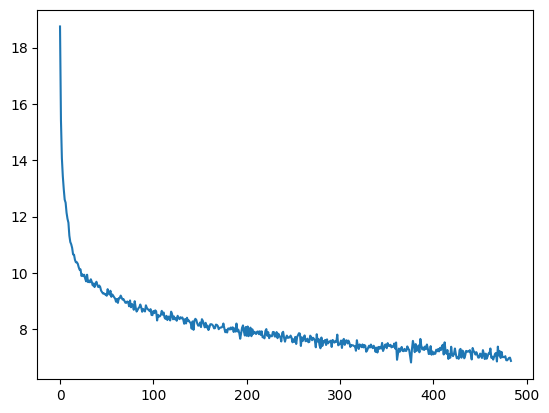

In [70]:
from matplotlib import pyplot as plt
plt.plot(losses)

In [72]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 assume space token exists; fallback to 0 if missing
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # prepend the pad once; from now on the window just slides

    idx = start_ids

    for _ in range(max_new_tokens):
        context = idx[:, -max_ctx:]  # rotating buffer: last pad_len+block_size tokens
        logits, _ = model(context, None)
        last_logits = logits[:, -1, :]
        probs = torch.softmax(last_logits / temperature, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat([idx, next_token], dim=1)

    # drop the initial pad when returning the string
    out_tokens = idx[0].tolist()
    return decode_chars(out_tokens, itos)
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO:"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=512,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=1.0
)

print(generated)

ROMEO:





IUSer en thrist ch, sirraw's my may thot that that enTIIIIIIIIIIII:

Getmence sayhf Romer, roingmught?

First:

MENENIUS:
Though now the would shall!
Where our servost command I becond to ento that. Lesence; nights myse and I world reprow if thou let's pricause me he her; headles. Harces, mucclingharge.

First Rofe, that, ear, geny's that evermen, of if in this.

ISABY:
Your lisdance as our send hear note: 'tisgrolle thirry that be in the go Have and as than nost my fellowst and Jay speak of inswer-da


In [40]:
torch.save(model, "fuzzy.pth")
